In [32]:
# libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import textwrap
import math
from matplotlib.animation import FuncAnimation
from matplotlib.patches import FancyArrowPatch
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from highlight_text import fig_text, ax_text

# parameters
interpolate = False
interpolate_factor = 10

# pre processing
df = pd.read_csv('global-plastics-production.csv')
df.columns = ['Entity', 'Code', 'Year', 'plastic-production']
df = df.set_index('Year')
df.sort_values(by='Year', inplace=True)
df.drop(['Entity', 'Code'], axis=1, inplace=True)

# add value for missing year 1974
df.loc[1974] = (df.loc[1973].values + df.loc[1975].values) / 2

# predict value with fitting for 2020 up to 2050
X = df.index.values.reshape(-1, 1)
y = df['plastic-production'].values
model = make_pipeline(PolynomialFeatures(2), LinearRegression())
model.fit(X, y)
X_pred = np.arange(2020, 2051).reshape(-1, 1)
y_pred = model.predict(X_pred)
df_pred = pd.DataFrame(y_pred, index=X_pred.flatten(), columns=['plastic-production'])
df = pd.concat([df, df_pred])

# interpolation
if interpolate:
   multiple = interpolate_factor
   new_index = np.linspace(df.index.min(), df.index.max(), len(df) * multiple-(multiple-1))
   df = df.reindex(new_index).interpolate(method='polynomial', order=2)
   df.reset_index(inplace=True)
   df['Year'] = df['index'].astype(int)
   df.index = df['Year']
   df.drop(columns=['index', 'Year'], inplace=True)
   df.index = new_index

df.sort_index(inplace=True)
df.head(5)

,plastic-production
1950,2000000.0
1951,2000000.0
1952,2000000.0
1953,3000000.0
1954,3000000.0


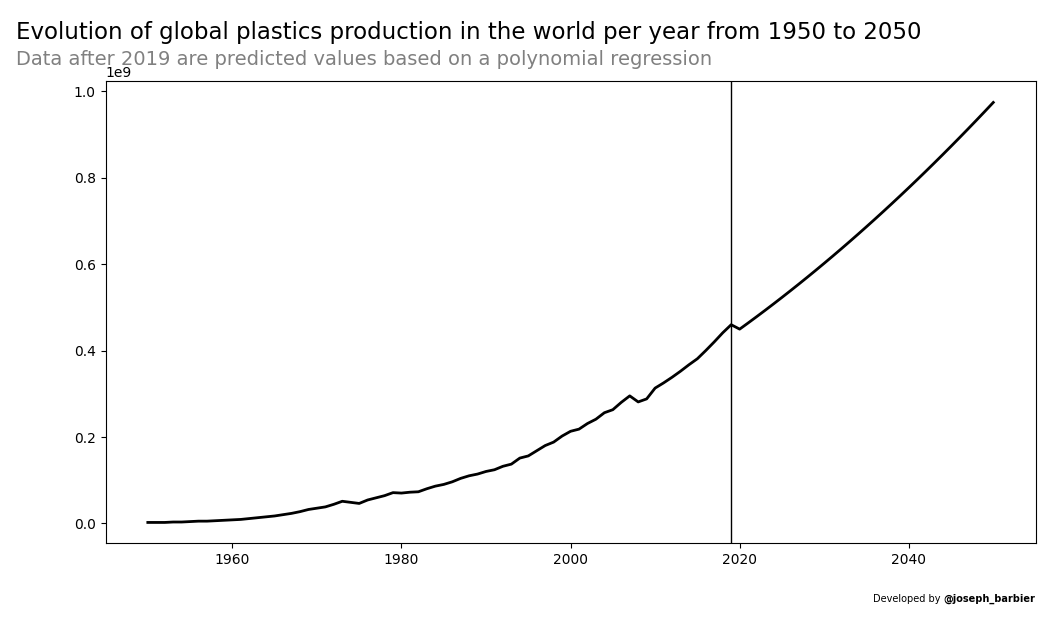

In [25]:
fig,ax = plt.subplots(figsize=(12, 6))
ax.plot(df.index, df['plastic-production'], color='black', linewidth=2)
ax.axvline(x=2019, color='black', linewidth=1)
text = """
Developed by <@joseph_barbier>
"""
fig_text(
   0.9, 0,
   text,
   ha='right', va='bottom',
   fontsize=7,
   color='black',
   highlight_textprops=[
      {'fontweight':'bold'},
   ],
   fig=fig
)
text = """
<Evolution of global plastics production in the world per year from 1950 to 2050>
<Data after 2019 are predicted values based on a polynomial regression>
"""
fig_text(
   0.05, 0.99,
   text,
   ha='left', va='top',
   highlight_textprops=[
      {'color':'black', 'fontsize':16.5},
      {'color':'grey', 'fontsize':14},
   ],
   fig=fig
)
plt.show()

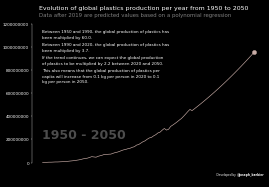

In [40]:
# parameters
background_color = 'black'
text_color = 'white'
line_color = '#c9ada7'

# description
prod_1950 = df.loc[1950, 'plastic-production']
prod_1990 = df.loc[1990, 'plastic-production']
prod_2020 = df.loc[2020, 'plastic-production']
prod_2050 = df.loc[2050, 'plastic-production']
pop_2020 = 7.82 * 10**9
pop_2050 = 9.7 * 10**9
description = f"""Between 1950 and 1990, the global production of plastics has been multiplied by {prod_1990/prod_1950:.1f}.

Between 1990 and 2020, the global production of plastics has been multiplied by {prod_2020/prod_1990:.1f}.

If the trend continues, we can expect the global production of plastics to be multiplied by {prod_2050/prod_2020:.1f} between 2020 and 2050.

This also means that the global production of plastics per capita will increase from {prod_2020/pop_2020:.1f} kg per person in 2020 to {prod_2050/pop_2050:.1f} kg per person in 2050.
"""

# Setting up the plot
fig, ax = plt.subplots(figsize=(10, 6), dpi=30)
fig.set_facecolor(background_color)
ax.set_facecolor(background_color)
ax.tick_params(axis='y', colors=text_color)
ax.spines[['left']].set_color(text_color)

# Update function for the animation
def update(frame):

    # skip first frame
    if frame == 0:
        return None

    # initialize subset of data
    subset_df = df.iloc[:frame]
    ax.clear()

    # create the line chart
    ax.plot(subset_df.index, subset_df['plastic-production'], color=line_color)
    ax.scatter(subset_df.index[-1], subset_df['plastic-production'].values[-1], color=line_color, s=100)

    # date in the background
    year = df.index[frame]
    fig_text(
        0.157, 0.3,
        '1950 - ' + str(round(year)),
        ha='left', va='top',
        fontsize=30,
        color=text_color,
        fontweight='bold',
        alpha=0.3,
        fig=fig
    )

    # custom axes
    y_min = df.iloc[:frame+1].sum(axis=1).min()
    y_max = df.iloc[:frame+1].sum(axis=1).max()
    ax.set_ylim(0, y_max*1.1)
    ax.spines[['top', 'right', 'bottom']].set_visible(False)
    #ax.set_yticks([tick for tick in ax.get_yticks()])
    #ax.set_yticklabels([round(label) for label in ax.get_yticks()], fontsize=10)


    # get text to display at current frame
    total_chars = len(description)
    effective_frame_count = len(df) - 40 # ends 40 frames before the end
    num_chars = math.ceil(total_chars * (frame / effective_frame_count)) if frame < effective_frame_count else total_chars
    current_description = description[:num_chars]
    wrapped_text = '\n'.join([textwrap.fill(paragraph, width=60) for paragraph in current_description.split('\n')])
    fig_text(
        0.157, 0.85,
        wrapped_text,
        ha='left', va='top',
        fontsize=10,
        color=text_color,
        fig=fig
    )

    # title
    text = """
    <Evolution of global plastics production per year from 1950 to 2050>
    <Data after 2019 are predicted values based on a polynomial regression>
    """
    fig_text(
        0.13, 0.99,
        text,
        ha='left', va='top',
        highlight_textprops=[
            {'color':text_color, 'fontsize':15},
            {'color':'grey', 'fontsize':13},
        ],
        fig=fig
    )

    # credit annotation
    text = """
    Developed by <@joseph_barbier>
    """
    fig_text(
        0.9, 0,
        text,
        ha='right', va='bottom',
        fontsize=7,
        color=text_color,
        highlight_textprops=[
            {'fontweight':'bold'},
        ],
        fig=fig
    )

# create and save animation
ani = FuncAnimation(fig, update, frames=len(df))
ani.save('global-plastics-production.gif', fps=20)